# Unsupervised Graph Learning

Unsupervised ML: subset of ML that do not exploit any target information during training. Where there is no teacher and no correct answer is known a *priori*. These have become a useful tool to solve downstream tasks, such as node classification, community detection etc..

Given a graph, the goal of the techniques is to automatically learn a latent representation of it, in which the key structural components are somehow preserved.

Due to the mathematical complexity of Graphs in non-Euclidean space, it is not always easy to define what is close to what. May be hard to say what *close* even means, two users can be connected yet share very different features, can we still consider them as "close"? So problems like these are the reason unsupervised ML algorithms have found large applications in graph analysis, as there is no need for manually annotated data; making use of the information in the adjacency matrix and node features without any knowledge of the downstream ML task.

One of the most used solutions is to learn embeddings that preserve graph structure. Learned representation can reconstruct pair-wise node similarity e.g. **adjacency matrix**. Can encode latent relationships to discover hidden and complex patterns. Reported by paper https://arxivorg/abs/2005.03675, algorithms can be grouped into macro-groups: shallow embedding methods, autoencoders and GNNs. 

![3_1](./figures/3_1.jpg)

## Shallow Embedding Methods
Learn and return embedding values for learned input data

### Matrix Factorisation
General decomposition technique widely used in different domains. Consistent number of graph embedding algorithms use this technique to compute node embedding of a graph.
Matrix factorisation learns the V and H matrices (W ~ V X H) where $V \isin \Re$ <sup>$m$ x $d$</sup> and  $H \isin \Re$ <sup>$d$ x $n$</sup> (called **source** and **abundance** matrix respectively) by minimising a loss function that can change according to the specific problem we want to solve. *d* is the number of dimensions of the generated embedding space. The loss fn. is defined by computing the reconstruction err. using the Frobenius Norm as $||W - V X H||^2_F$. 

Generally speaking, all the unsupervised embedding algorithms based on matrix factorisation use the same principle. They factorise an input graph expressed as a matrix in different components. Differences lie in the loss functions used in the optimisation process. Different loss functions create embedding spaces that emphasise specific graph properties.

### Graph Factorisation
GF algorithm factorises the adjacency matrix of a given graph. 
$L = 1/2 \sum\limits_{(i,j) \isin E} (A$ <sub>$i,j$</sub> $- Y_i,Y_j^T)^2 + \lambda/2 \sum\limits_{i}||Y_t||^2$
May also include a regularisation term $\lambda$ to make sure the problem remains well-posed in the absence of sufficient data. Suitable for undirected graph, has a strong symmetric factorisation. But could be limited for undirected graphs.

In [1]:
import networkx as nx
from gem.embedding.gf import GraphFactorization

G = nx.barbell_graph(m1=10, m2=4)

# generate d=2 dimensional embedding space
gf = GraphFactorization(d=2, data_set=None, max_iter=10000, eta=1*10**-4, regu=1.0)
# computation of node embeddings of input graph
gf.learn_embedding(graph=G)
# extracted computed embedding by calling gf.get_embedding()
embeddings = gf.get_embedding()

[Errno 2] No such file or directory: 'gem/c_exe/gf'
./gf not found. Reverting to Python implementation. Please compile gf, place node2vec in the path and grant executable permission
		Iter id: 0, Objective: 95.0074, f1: 95.0032, f2: 0.00421903


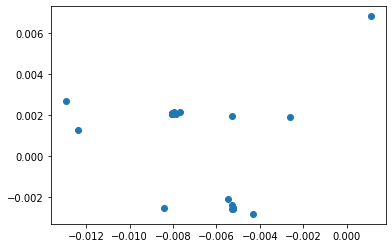

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# we can see approx. 3 groupings
plt.scatter(embeddings[:,0], embeddings[:,1])

**Higher-order proximity preserved embedding (HOPE)** is another graph embedding technique based on matrix factorisation. This method preserves higher-order proximity and does not force its embeddings to have symmetric properties.
-  **First-order proximity**: We say a vertex pair $(v_i, v_j)$ has first-order proximity equal to edge weight $W$<sub>$ij$</sub> if edge $(v_i, v_j) \isin E$. Otherwise, the first-order proximity between the two nodes is 0.
-  **Second and high-order proximity**: Capture two-step relationships between each pair of vertices. For each vertex pair $(v_i, v_j)$, second-order proximity is a two-step transition from $v_i$ to $v_j$. Higher-order proximity generalises this and we can capture a more global structure. Higher-order proximity can be viewed as k-step transition from $v_i$ to $v_j$.

Loss function for HOPE is $L = ||S - Y_s \times Y_t^T||^2_F$ where $S$ is the similarity matrix from graph $G$ and $Y_s \isin \Re$<sup>$|V|xd$</sup> and $Y_t \isin \Re$<sup>$|V|xd$</sup> are two ebedding matrices representing *d*-dimensional embedding space. $Y_s$ represents source embedding and $Y_t$ represents target embedding. HOPE uses two matrices to capture asymmetric proximity in directed networks where the direction from source node and target node is present. The final embedding matrix, Y, is obtained by concatenating column-wise $Y_s$ and $Y_t$ matrices, so the final embedding space has $2 * d$ dimensions.

*S* is a similarity matrix from graph *G*, it's goalis to obtain higher-order proximity information. Formally computed as $S=M_g \cdot M_t$ where $M_g$ and $M_t$ are polynomials of matrices. Some ways to compute $M_g$ and $M_t$ are:
-  **Academic Adar(AA)**: Here, $M_g = I (identity)$ and $M_t = A \cdot D \cdot A$ where $D$ is a diagonal matrix computed as $D$<sub>$ij$</sub> $ = 1/ (\sum (A_i $<sub>$j$</sub> $+ A_j$ <sub>$i$</sub> $))$
-  **Katz Index**
-  **Rooted PageRank (RPR)**
-  **Common Neighbors (CN)** etc..

In [3]:
import networkx as nx
from gem.embedding.hope import HOPE

G = nx.barbell_graph(m1=10, m2=4)
# different class initialization with HOPE
# d represents dimension of embedding space, num of columns of final embedding matrix Y
# Y is obtained after column-wise concatenation of Y_s and Y_t
gf = HOPE(d=4, beta=0.01)
gf.learn_embedding(graph=G)
embeddings = gf.get_embedding()

SVD error (low rank): 0.052092


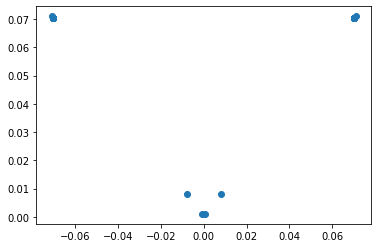

In [4]:
# can see better grouping/separation of models
plt.scatter(embeddings[:,0], embeddings[:,1])

**Graph Representation with Global Structure Information**

Graph representation with global structure information, such as HOPE allows us to preserve higher-order proximity without forcing embeddings to have symmetric properties. Formally, let $G = (V, E)$ be the graph we want to compute node embeddings for and $A \isin \Re$<sup>$|V| \times |V|$</sup> be its adjacency matrix, we have the loss function:
$L_k = ||X^k - Y_s^k \times Y_t $<sup>$k^T$</sup>$||^2_F 1 \le k \le K $. In the loss fn, $X^k \isin \Re$<sup>$|V|\times|V|$</sup> is a matrix generated from graph *G* to get the *k*th order of proximity between nodes. 

$Y_s^k \isin \Re$<sup>$|V|\times|V|$</sup> and $Y_t^k \isin \Re$<sup>$|V|\times|V|$</sup> are two embedding matrices representing a d-dimensional embedding space of *k*th order proximity for source and target nodes, respectively. The $X^k$ matrix is computed according to the equation $X^k = \prod\limits_{k}(D$<sup>$-1$</sup>$A)$ where D is a diagonal **degree matrix** computed where $D$<sup>ij</sup>$=\sum\limits_{p} A$<sub>ip</sub> where $i=j$. 

$X^1 = D$<sup>-1</sup>$A$ represents the (one-step) probability transition matrix where Xij is the probability of transition from vertex $V_i$ to $V_j$. Generally, $V^k$<sub>ij</sub> represents the probability of transition from $V_i$ to $V_j$ within *k* steps. For each order of proximity, k, an independent optimisation is fitted. All the k embedding matrices generated are then column-wise concatenated to get the final source embedding matrices.

In [1]:
# node embedding for karateclub
import networkx as nx
from karateclub.node_embedding.neighbourhood.grarep import GraRep

G = nx.barbell_graph(m1=10, m2=4)
# dimensions of embedding space and max num orders of proximity between nodes
gr = GraRep(dimensions=2, order=3) 
gr.fit(G)
# num columns here is dimensions * order
embeddings = gr.get_embedding()

In [2]:
embeddings.shape

(24, 6)

Different orders of proximity allow us to get different embeddings. Since input graph is simple, for *k=1*, a well-separated embedding space is obtained.

### Skip-gram

Skip-gram model is a simple NN with one hidden-layer trained to predict the probability of a given word being present when an input word is present, the NN is trained by building the training data using a text corpus as reference. 

Training: A target word is selected and a rolling window of fixed size *w* is built around the word, the other words inside the rolling window are known as *context* words. So wehave multiple pairs of *(target word, context word)* which are built according to words inside the rolling window.

Once training data is generated from the whole corpus, the skip-gram model is trained to predict the probability of a word being a context word for the given target. During training, the NN learns a compact representation of input words, this is why the model is known as **Word to Vector (Word2Vec)**.

The input is a binary vector of size *m*. Each element of the vector represents a word in the dict of the language we want to embed words in. In training, a *(target word, context word)* pair is given, the input array will have 0 in all its entries with the exception of the entry representing the "target" word which will be 1. The hidden layer has *d* neurons and will learn the embedding representation of each word, creating a *d-*dimensional embedding space.

Finally, output layer is a dense layer of *m* neurons (same size as input vector) with *softmax* activation. Each neuron represents a word of the dictionary and its value corresponds to the probability of that word being "related" to the input word. Since softmax can be hard to compute as *m* increases, a *hierarchical softmax* approach is used.

Our final goal is to not learn the actual task, but to build a compact *d*-dimensional representation of the input words. So we can extract an embedding space for words using the weights of the hidden layer. Another approach is **continuous bag-of-words (CBOW)** which is a context-based skip-gram model. Generally speaking, all unsupervised embedding algorithms based on skip-gram model use the same principle. Start from input graph, they extract from set of walks, these can be seen as a text corpus, whereby connected is a text next to each other. This leads us to DeepWalk.

### DeepWalk

Generates node embeddings of a graph using skip-gram model, for this we introduce **random walk**. Here we select vertex $v_i$ as starting node, then pick neighbour at random and move towards it. We repeat this *t* times so we have random walk of length *t*. There is no guarantee that the local neighbourhood of the node is well preserved as the random walk algorithm has no constraint on how they are built. The *t* walks are used as input to the skip-gram model. The embedding generated by skip-gram will be used as final node embedding. So breaking it down:
1.  **Random Walk Generation**: For each node of input graph G, set of $Y$ random walks with fixed max length (t) is computed. Note that *t* is an upper bound, no constraints forcing all paths to have the same length.
2.  **Skip-Gram Training**: Use walks generated in previous step. When graph is given as input to skip-gram, input can be seen as text corpus where the node is the word of the corpus.
3.  **Embedding Generation**: Information contained in hidden layers of trained skip-gram model is used to extract embedding of each node.

In [51]:
import networkx as nx
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk

G = nx.barbell_graph(m1=10, m2=4)
# walk_number: number of random walks to generate for each node
# walk_length: length of the generated random walks
# window_size: window size parameter of the skip-gram model
dw = DeepWalk(dimensions=2)
dw.fit(G)
embeddings = dw.get_embedding()

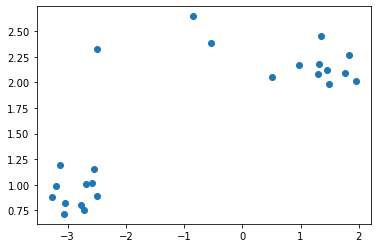

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline 

# there is not that clear of a distinction between the embedding space of the nodes
plt.scatter(embeddings[:,0], embeddings[:,1]);

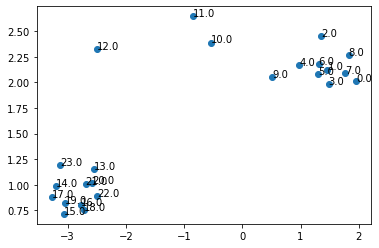

In [53]:
import numpy as np
v_embeddings = np.array([(nid, *embeddings[nid]) for nid in G.nodes])
# separation between nodes is better compared to DeepWalk. Regions 1 and 3 are clustered in space
# region2 is in the middle without overlap with region1 and region3

fig, ax = plt.subplots()
ax.scatter(v_embeddings[:,1], v_embeddings[:,2])

for v in v_embeddings:
    ax.annotate(v[0], (v[1], v[2]))

### Node2Vec
Similar to DeepWalk, generates set of random walks as input to skip-gram and then use hidden layer to generate node embeddings. Difference is in the way random walks are generated.

In Node2Vec, a new technique to generate biased random walks on the graph is introduced. This algorithm combines **Breadth-First Search (BFS)** and **Depth-First Search (DFS)**. These two are regulated by parameters *p* and *q*.
-  **p**: Probability of random walk going back to previous node
-  **q**: probability that random walk passes through previously unseen part of graph

So here Node2Vec can preserve high-order proximities by preserving local graph structures as well as globalcommunity structures. So this preserves local neighbourhood properties of the node.

Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 152.76it/s]


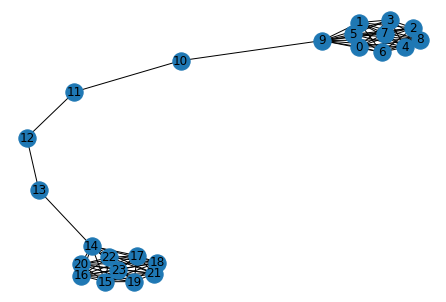

In [2]:
import networkx as nx
from node2vec import Node2Vec
G = nx.barbell_graph(m1=10, m2=4)
nx.draw(G, with_labels=True)
# num walks: number of random walks to generate for each node
# walk_length: length of the generated random walks
# p and q: parameters of the random walk
node2vec = Node2Vec(G, dimensions=2, num_walks=10)
model = node2vec.fit(window=10)
embeddings = model.wv
# can use model.wv[str(nodeId)] to get the embedding of a node

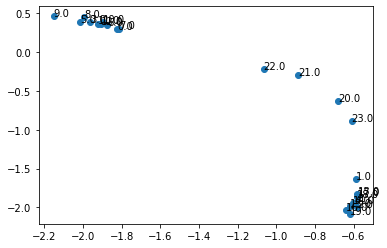

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

v_embeddings = np.array([(nid, *embeddings[nid]) for nid in G.nodes])
# separation between nodes is better compared to DeepWalk. Regions 1 and 3 are clustered in space
# region2 is in the middle without overlap with region1 and region3

fig, ax = plt.subplots()
ax.scatter(v_embeddings[:,1], v_embeddings[:,2])

for v in v_embeddings:
    ax.annotate(v[0], (v[1], v[2]))

### Edge2Vec
Edge2Vec generates embedding space on edges instead of nodes, this uses node embedding of two adjacent nodes to perform some basic mathematical operations in order to extract the embedding of the edge connecting them.

Can compute embeddings with average embedder, Hadamard, Weighted-L1 or Weighted L2

In [6]:
from node2vec.edges import HadamardEmbedder
# value of param is Node2Vec embeding model.
# to change the embedding model, change the value of param
embedding = HadamardEmbedder(keyed_vectors=model.wv)
# different embedding methods create different embeding spaces

### Graph2Vec
Generates embeddings for the whole graph. Generate an embedding space where each point represents a graph, this is an evolution of Word2Vec skip-gram known as **Document to Vector (Doc2Vec)**. Compared to Word2Vec Doc2Vec accepts another binary array representing the document containing the input word. Given a 'target' document and 'target' word, the model tries to predict the most probable 'context' word wrt the input 'target' word and document.

So then with Graph2Vec, we see the entire graph as a document and each of its subgraphs, generated as an ego graph of each node as words that comprise the document. Ie. a graph is composed of subgraphs as a document is composed of sentences, so we summarise the algorithm to the following steps:
1.  **Subgraph Generation**: Set of rooted subgraphs is generated around every node
2.  **Doc2Vec Training**: Doc2Vec skip-gram is trained using the subgraphs generated by the previous step
3.  **Embedding Generation**: Information in hidden layers of Doc2Vec is used to extract embedding of each node


In [11]:
import matplotlib.pyplot as plt
from karateclub import Graph2Vec
import random
n_graphs=20

def generate_random():
    n = random.randint(5, 20)
    k = random.randint(5, n)
    p = random.uniform(0, 1)
    return nx.watts_strogatz_graph(n,k,p)

Gs = [generate_random() for x in range(n_graphs)] # generate 20 watts-strogatz graphs

model = Graph2Vec(dimensions=2) # 2 dimensions
model.fit(Gs) # fit model
embeddings = model.get_embedding() # extract embeddings

More complex graph embedding algorithms based on autoencoders.

## Autoencoders